## 介绍

回测使用的数据按变化频率划分三类。第一类为密集型，即`CNEquityPricing`(或`USEquityPricing`)，特点是变化频率高，频率或是每日或是分钟级别。另一部分是偶发性，如季度报告，公司更名，其特点是变化频率不快，或是季度性，或是不定期偶发。另外一部分为固定信息，如IPO日期，一旦上市，其日期永远不会发生变化。为简化处理，对于股票概念、地区、行业等分类信息，也划归此类处理。

`Fundamentals`是用于`pipeline`的数据集容器，包括上述二、三类数据，如上市日期、行业分类、所属概念、财务数据、融资融券（数据量小，并入处理）等信息。

## `CNEquityPricing`

### 调整列
此类数据当股票发生分红派息时，为保持数据纵向一致性及满足账户管理要求，数据会自动调整。调整列包括：
+ close
+ open
+ high
+ low
+ volume

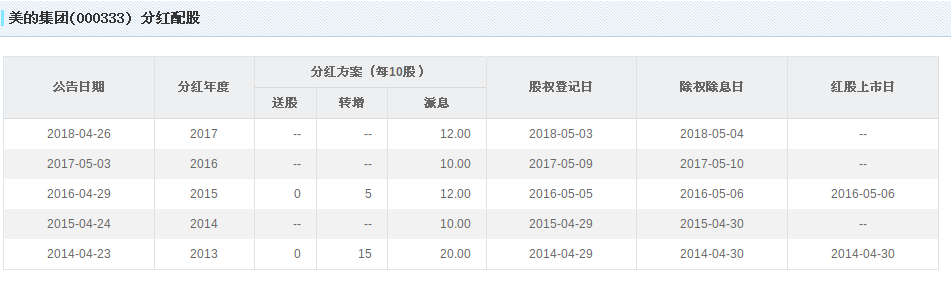

![000333_adj.png](attachment:000333_his.png)

In [1]:
from zipline.research import run_pipeline, select_output_by
from zipline.pipeline import Pipeline
from zipline.pipeline.data import CNEquityPricing

In [2]:
def make_pipeline():

    return Pipeline(
        columns={
            '收盘价': CNEquityPricing.close.latest,
            '成交量': CNEquityPricing.volume.latest,
        })

#### 分红派息

In [3]:
result = run_pipeline(make_pipeline(), '2016-5-4', '2016-5-13')

In [4]:
select_output_by(result,stock_codes=['000333']) #,'000001'])

,,成交量,收盘价
2016-05-04 00:00:00+00:00,美的集团(000333),29620000.0,33.840000
2016-05-05 00:00:00+00:00,美的集团(000333),27680000.0,32.960000
2016-05-06 00:00:00+00:00,美的集团(000333),29310000.0,21.193333
2016-05-09 00:00:00+00:00,美的集团(000333),38780000.0,20.350000
2016-05-10 00:00:00+00:00,美的集团(000333),32280000.0,20.350000
2016-05-11 00:00:00+00:00,美的集团(000333),48140000.0,21.080000
2016-05-12 00:00:00+00:00,美的集团(000333),58910000.0,21.960000
2016-05-13 00:00:00+00:00,美的集团(000333),40700000.0,21.900000


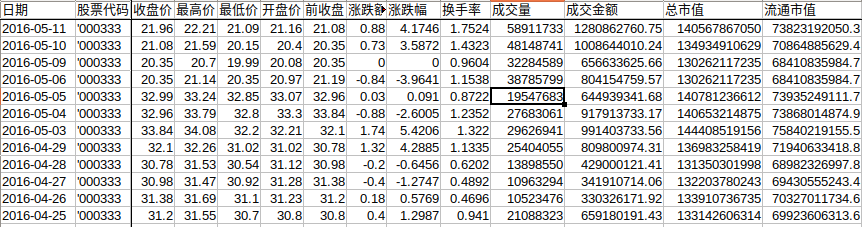

当回测日期为5月5日时，尾部窗口日期为其上一个交易日，即5月4日，其实际收盘价为32.96，观测期间未发生分红送配，所以不会存在调整。`pipeline`输出结果也为32.96。

当回测日期为5月6日时，尾部窗口日期为其上一个交易日，即5月5日，其实际收盘价为32.99，观测期间发生分红送配，每股派息1.2元，转赠0.5股，收盘价调整为21.193333。

$$adjusted = \frac{price - div}{1 + split}$$

同理，成交量在送转时也会调整。5月5日实际成交量为19547683(存储数据时，成交量调整为万股，即1954,读取时还原为19540000,损失一点精度)，调整后的成交量为2931。

$$adjusted = volume * (1 + split)$$

In [5]:
from numpy.testing import assert_almost_equal

In [6]:
df = select_output_by(result, stock_codes=['000333'])
assert_almost_equal(df.loc['2016-05-05']['收盘价'][0], 32.96)
assert_almost_equal(df.loc['2016-05-06']['收盘价'][0], (32.99 - 1.2) / (1 + 0.5), 2)
assert_almost_equal(df.loc['2016-05-06']['成交量'][0], 1954 * 10000 * (1 + 0.5), 2)

#### 仅派息

In [7]:
result = run_pipeline(make_pipeline(), '2017-5-8', '2017-5-13')

In [8]:
select_output_by(result,stock_codes=['000333'])

,,成交量,收盘价
2017-05-08 00:00:00+00:00,美的集团(000333),55050000.0,36.15
2017-05-09 00:00:00+00:00,美的集团(000333),31840000.0,35.68
2017-05-10 00:00:00+00:00,美的集团(000333),38160000.0,34.30
2017-05-11 00:00:00+00:00,美的集团(000333),39320000.0,35.15
2017-05-12 00:00:00+00:00,美的集团(000333),40890000.0,35.82


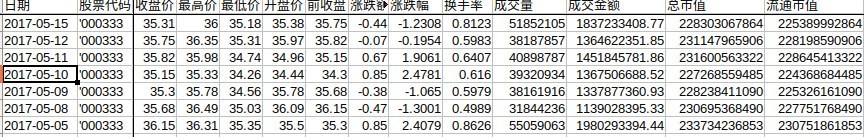

In [9]:
df = select_output_by(result, stock_codes=['000333'])
assert_almost_equal(df.loc['2017-05-10']['收盘价'][0], 35.30 - 1.0)
assert_almost_equal(df.loc['2017-05-10']['成交量'][0], 38160000, 2)

### 非调整列
成交额、换手率、总市值、流通市值等数据不会因分红派息发生调整。

In [10]:
def make_pipeline():

    return Pipeline(
        columns={
            '成交额': CNEquityPricing.amount.latest,
            '换手率': CNEquityPricing.turnover.latest,
            '总市值': CNEquityPricing.tmv.latest,
            '流通市值': CNEquityPricing.cmv.latest,
            '流通股本': CNEquityPricing.circulating_share.latest,
            '总股本': CNEquityPricing.total_share.latest,
        })

In [11]:
result = run_pipeline(make_pipeline(), '2016-5-4', '2016-5-9')

In [12]:
select_output_by(result,stock_codes=['000333']) #,'000001'])

,,总市值,总股本,成交额,换手率,流通市值,流通股本
2016-05-04 00:00:00+00:00,美的集团(000333),1.444085e+11,4.267390e+09,991400000.0,0.013220,7.584021e+10,2.241140e+09
2016-05-05 00:00:00+00:00,美的集团(000333),1.406532e+11,4.267390e+09,917910000.0,0.012352,7.386801e+10,2.241140e+09
2016-05-06 00:00:00+00:00,美的集团(000333),1.407812e+11,4.267390e+09,644930000.0,0.008722,7.393524e+10,2.241140e+09
2016-05-09 00:00:00+00:00,美的集团(000333),1.302621e+11,6.401080e+09,804150000.0,0.011538,6.841083e+10,3.361710e+09


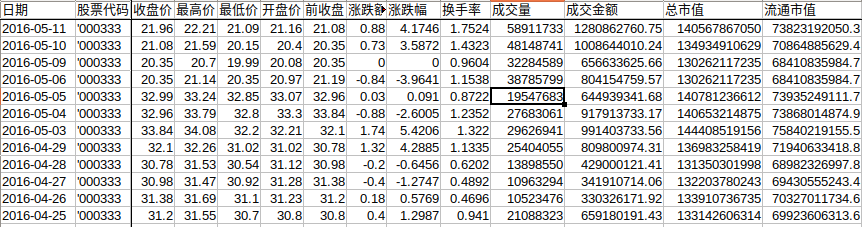

In [15]:
df = select_output_by(result, stock_codes=['000333'])
assert_almost_equal(df.loc['2016-05-05']['总市值'][0], int(140653214875 / 10000) * 10000)
assert_almost_equal(df.loc['2016-05-05']['换手率'][0], 0.012352)
assert_almost_equal(df.loc['2016-05-05']['流通股本'][0], int(73868014874 / 32.96 / 10000) * 10000)

## `Fundamentals`

In [ ]:
from zipline.pipeline.fundamentals import Fundamentals

### 查询数据集列编码
+ 输入数据集列名称所包含关键字
+ 返回列编码字典（A + 三位整数）

In [ ]:
Fundamentals.query_cashflow_code('资金')

In [ ]:
Fundamentals.query_concept_code('生物')

In [ ]:
# 无数据，返回空字典
Fundamentals.query_concept_code('oo')

### 数据集列名称

In [ ]:
Fundamentals.balancesheet_col_name('A001')

In [ ]:
Fundamentals.profit_col_name('A023')

In [ ]:
Fundamentals.cashflow_col_name('A010')

In [ ]:
# 超出数据集列长度，触发KeyError
# Fundamentals.query_profit_name('A123')

### 查询编码含义

In [ ]:
Fundamentals.market_cname(3)

In [ ]:
Fundamentals.sector_cname(9)

In [ ]:
Fundamentals.sector_cname(6)

In [ ]:
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline import Pipeline
from zipline.research import run_pipeline

### 案例

In [ ]:
def make_pipeline():
    market = Fundamentals.info.market.latest
    sector_code = Fundamentals.info.sector_code.latest
    mean_close_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close], window_length=10)
    return Pipeline(columns={
        '10_day_mean_close': mean_close_10,
        'market': market,
        'sector_code': sector_code,
    })

In [ ]:
result = run_pipeline(make_pipeline(), '2018-04-10', '2018-04-10')
result.head(5)